In [6]:
import re
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/home/jiahang/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import scipy
import utils_dagma
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score
from copy import deepcopy
import fdr_control

2024-10-28 18:02:38.014944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 18:02:38.032069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 18:02:38.037247: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 18:02:38.050064: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 18:02:38.806100: W tensorflow/compiler/tf2

In [54]:
def fdr_log(Z, W_true, n_jobs, print_all=True):
    W_true = true_data['W_true']
    
    from joblib import Parallel, delayed
    from tqdm import tqdm
    from copy import deepcopy
    fdr=0.2
    num_feat = 100
    est_type = 'tau+'
    n_jobs = 1
    
    print(f"==============================")
    print(f"expected FDR {fdr}")
    
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
    
    T_T_true = np.abs(W_true)
    mask = (T_T_true > 0.)
    T_T_true[mask], T_T_true[~mask] = 1, 0
    
    fdr_est_last = 1.
    t_last = np.inf
    
    def _get_t(t_list: list):
        t_last = np.inf
        fdr_est_last = None
        for t in reversed(t_list):
            if t < 0.:
                break
            if est_type == 'tau':
                fdr_est = ((Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
            else:
                fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
            
            T_T = Z.copy()
            mask = (T_T >= t)
            T_T[mask], T_T[~mask] = 1, 0
            perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
            fdr_true, power = perf['fdr'], perf['tpr']
            if print_all:
                print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")
    
            if fdr_est <= fdr:
                t_last = t
                fdr_est_last = fdr_est
        return t_last, fdr_est_last
        
    interval = len(t_list) // n_jobs
    intervals = [(j * interval, (j+1) * interval) for j in range(n_jobs - 1)]
    intervals.append(
        ((n_jobs-1) * interval, len(t_list))
    )
    res1 = []
    res1 = Parallel(n_jobs=n_jobs)(
            delayed(_get_t)(
                t_list[interval[0]:interval[1]]
            ) for interval in intervals
        )
    
    
    res = np.array([list(_res) for _res in res1 if not np.isinf(_res[0]) and _res[1] is not None])
    if len(res) > 0: # otherwise, no edge being selected
        t_last = res[:, 0].min()
        t_last_idx = np.argmin(res[:, 0])
        fdr_est_last = res[t_last_idx, 1]
    
    mask = (Z >= t_last)
    Z[mask], Z[~mask] = 1, 0
    T_T = Z
    
    perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
    fdr_true, power = perf['fdr'], perf['tpr']
    
    if utils_dagma.is_dag(T_T):
        print("W_est is DAG")
    else:
        print("W_est is NOT DAG")
    print(f"expected fdr {fdr:.1f} | sel thresh {t_last:.4e} | "
          f"est fdr {fdr_est_last:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")
    print(f"==============================")
    return fdr_true, power

In [11]:
path = '/home/jiahang/dagma/src/dagma/simulated_data/v53/v2000_40_240_normX=sym1_option=5_knock=PLS_l1=0.1_l2=0.1/'
with open(path + f'X/X_1.pkl', 'rb') as f:
    true_data = pickle.load(f)
X = true_data['X']
W_true = true_data['W_true']
B_true = (W_true != 0)

In [29]:
Z_dict = {}
# try 1: L1+L2, alpha=1, l1_ratil=0.1, l2_ratio=0.9
lambda_l1s = [0.1, 0.5, 0.9]
lambda_l2s = [0.1, 0.5, 0.9]

for l1 in lambda_l1s:
    for l2 in lambda_l2s:
        path = f'/home/jiahang/dagma/src/dagma/simulated_data/v53/v2000_40_240_normX=sym1_option=5_knock=PLS_l1={l1}_l2={l2}/W/W_1_1_0.pkl'
        with open(path, 'rb') as f:
            W_full = pickle.load(f)['W_est']
        d = 40
        Z_dict[f"l1={l1} | l2={l2}"] = np.abs(W_full[:d, :d]) - np.abs(W_full[d:, :d])

In [55]:
data = {}
fdr = {}
for key, val in Z_dict.items():
    data[f'true | {key}'] = val[B_true].flatten()
    data[f'false | {key}'] = val[~B_true].flatten()
    fdr[key] = fdr_log(Z_dict[key].copy(), W_true, 1, False)

expected FDR 0.2
W_est is NOT DAG
expected fdr 0.2 | sel thresh 1.8021e-02 | est fdr 0.2000 | true fdr 0.5288 | true power 0.5792
expected FDR 0.2
W_est is NOT DAG
expected fdr 0.2 | sel thresh 2.3418e-02 | est fdr 0.2000 | true fdr 0.6273 | true power 0.5125
expected FDR 0.2
W_est is NOT DAG
expected fdr 0.2 | sel thresh 3.2604e-02 | est fdr 0.1984 | true fdr 0.6032 | true power 0.4167
expected FDR 0.2
W_est is NOT DAG
expected fdr 0.2 | sel thresh 1.6828e-01 | est fdr 0.1923 | true fdr 0.3462 | true power 0.0708
expected FDR 0.2
W_est is DAG
expected fdr 0.2 | sel thresh 2.7081e-01 | est fdr 0.1250 | true fdr 0.0000 | true power 0.0333
expected FDR 0.2
W_est is DAG
expected fdr 0.2 | sel thresh 2.6886e-01 | est fdr 0.2000 | true fdr 0.0000 | true power 0.0208
expected FDR 0.2
W_est is DAG
expected fdr 0.2 | sel thresh inf | est fdr 1.0000 | true fdr 0.0000 | true power 0.0000
expected FDR 0.2
W_est is DAG
expected fdr 0.2 | sel thresh inf | est fdr 1.0000 | true fdr 0.0000 | true pow

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'true | l1=0.1 | l2=0.1'),
  Text(1, 0, 'false | l1=0.1 | l2=0.1'),
  Text(2, 0, 'true | l1=0.1 | l2=0.5'),
  Text(3, 0, 'false | l1=0.1 | l2=0.5'),
  Text(4, 0, 'true | l1=0.1 | l2=0.9'),
  Text(5, 0, 'false | l1=0.1 | l2=0.9'),
  Text(6, 0, 'true | l1=0.5 | l2=0.1'),
  Text(7, 0, 'false | l1=0.5 | l2=0.1'),
  Text(8, 0, 'true | l1=0.5 | l2=0.5'),
  Text(9, 0, 'false | l1=0.5 | l2=0.5'),
  Text(10, 0, 'true | l1=0.5 | l2=0.9'),
  Text(11, 0, 'false | l1=0.5 | l2=0.9'),
  Text(12, 0, 'true | l1=0.9 | l2=0.1'),
  Text(13, 0, 'false | l1=0.9 | l2=0.1'),
  Text(14, 0, 'true | l1=0.9 | l2=0.5'),
  Text(15, 0, 'false | l1=0.9 | l2=0.5'),
  Text(16, 0, 'true | l1=0.9 | l2=0.9'),
  Text(17, 0, 'false | l1=0.9 | l2=0.9')])

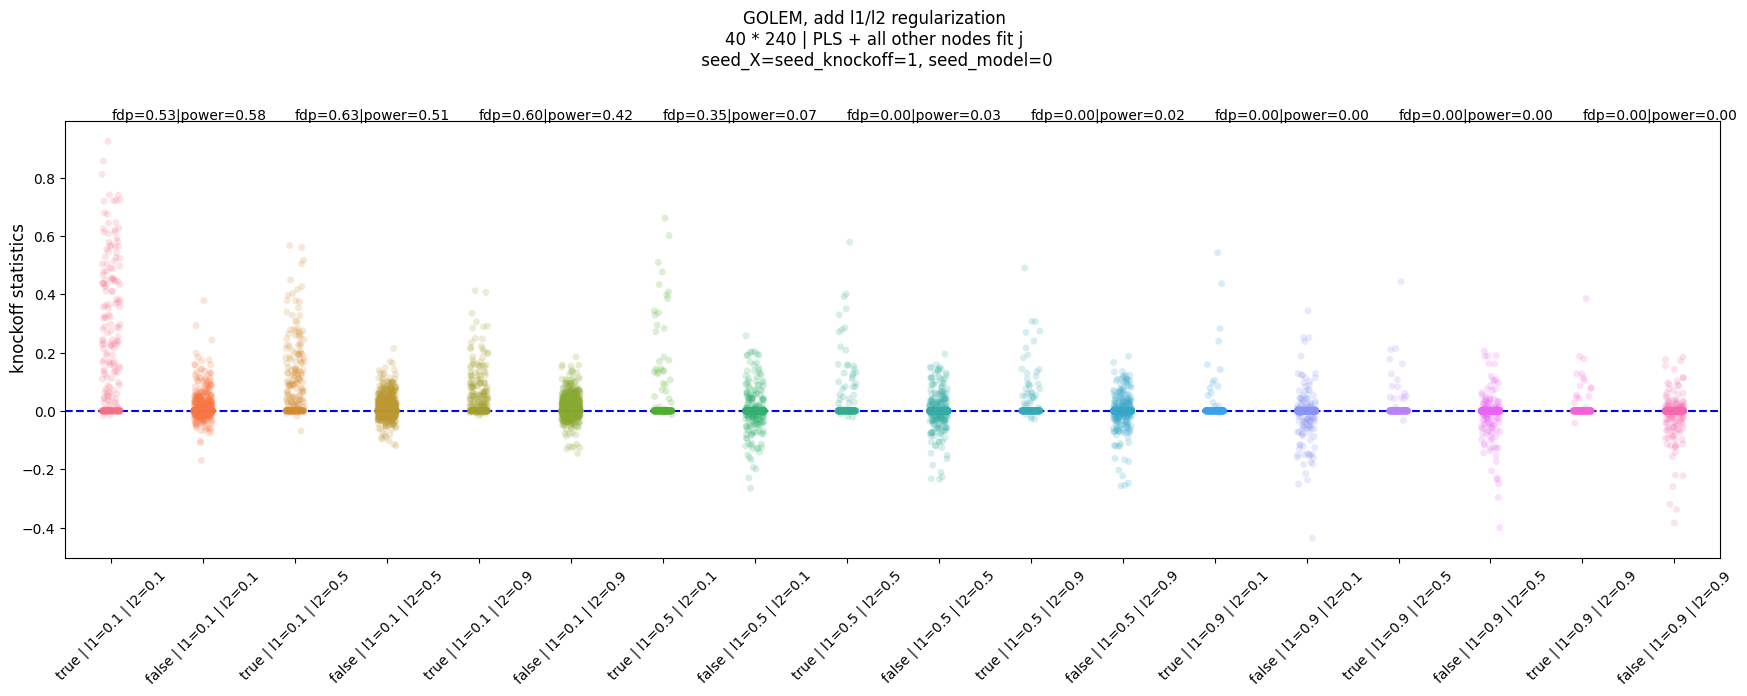

In [56]:
fig, axs = plt.subplots(1, 1, figsize=(18, 6))

ax = axs
    
sns.stripplot(data, alpha=0.2, ax=ax)
ax.axhline(0, linestyle='--', color='blue')
# ax.set_title("ElasticNet | alpha=1; l1_ratio=0.1/0.5/0.9")
cnt = 0
for key, val in fdr.items():
    ax.text(2 * cnt, 1, f'fdp={val[0]:.2f}|power={val[1]:.2f}')
    cnt += 1

fig.suptitle("GOLEM, add l1/l2 regularization\n40 * 240 | PLS + all other nodes fit j\n seed_X=seed_knockoff=1, seed_model=0\n")
fig.supylabel('knockoff statistics')
fig.tight_layout()
plt.xticks(rotation=45)

In [41]:
fdr_log(Z_dict['l1=0.5 | l2=0.5'].copy(), W_true, 1, False)

expected FDR 0.2
W_est is DAG
expected fdr 0.2 | sel thresh 2.7081e-01 | est fdr 0.1250 | true fdr 0.0000 | true power 0.0333
